## Mini EDA for Causal Analysis

03 de abril 2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm 
import causalpy as cp

In [2]:
# Cargar los archivos
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
# Ajustes visuales iniciales
sns.set(style="whitegrid")

**1. Modelo Predictivo:**
- Variable respuesta: Exited (abandono del cliente / churn).
- Debemos explorar variables predictivas relevantes.

**2. Enfoque Causal:**
- Debemos identificar variables que puedan funcionar como intervenciones ("tratamientos") o variables clave desde un enfoque conductual como:
- Loss Aversion: Evaluar beneficios percibidos (podría relacionarse a variables como NumOfProducts, Balance, o EstimatedSalary).



---

- Distribución y relaciones de variables clave con Exited.

- Potenciales confusores.

- Relaciones que podrían señalar intervenciones conductuales (proxies).



In [3]:
# Revisa estructura de los datos
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB
None


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
# Nulls 
print(train.isnull().sum())
print(test.isnull().sum())

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64


In [5]:
train.dtypes


id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

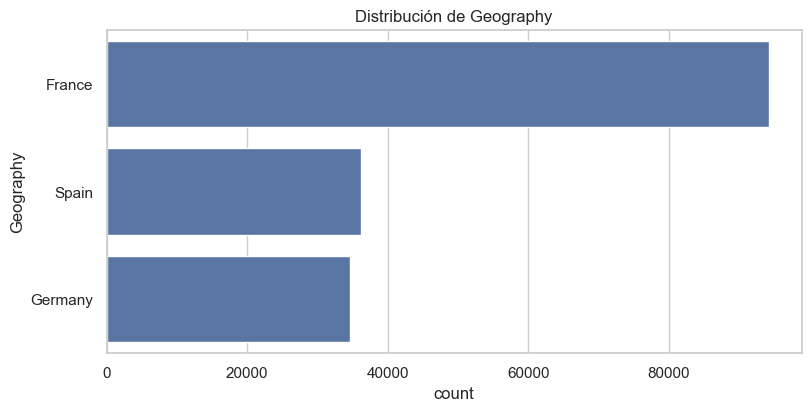

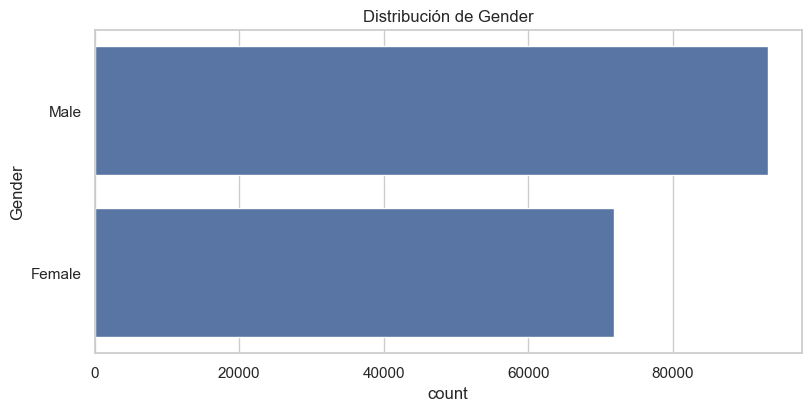

In [6]:
categoricas = train.select_dtypes(include=['object']).drop(columns=['Surname']).columns


for col in categoricas:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=train, order=train[col].value_counts().index)
    plt.title(f"Distribución de {col}")
    plt.show()


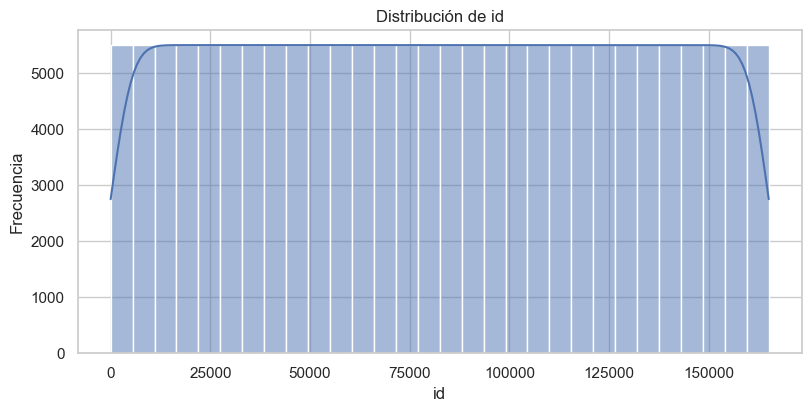

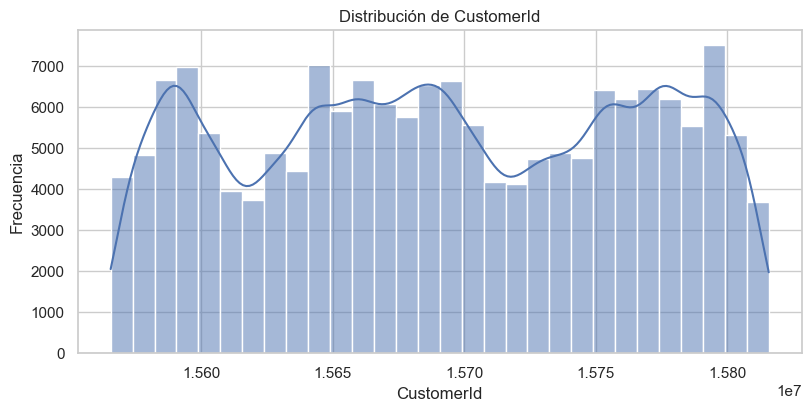

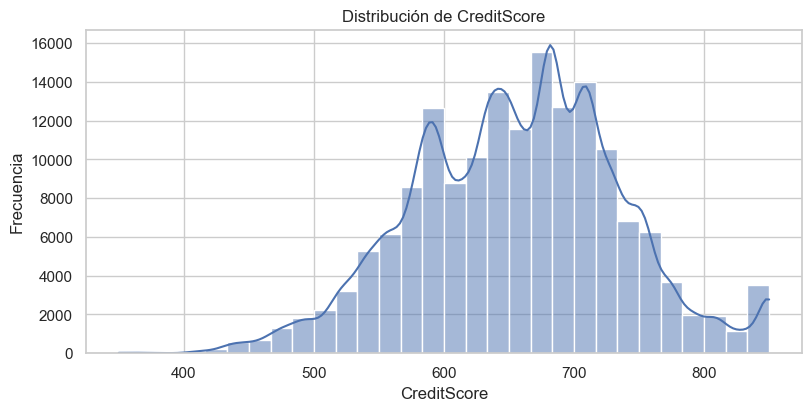

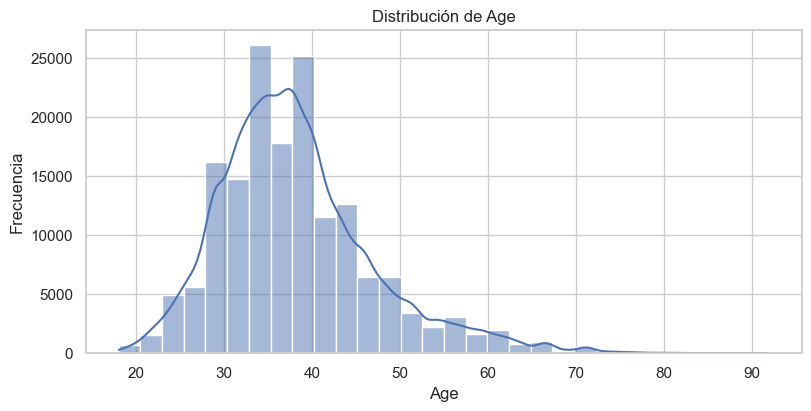

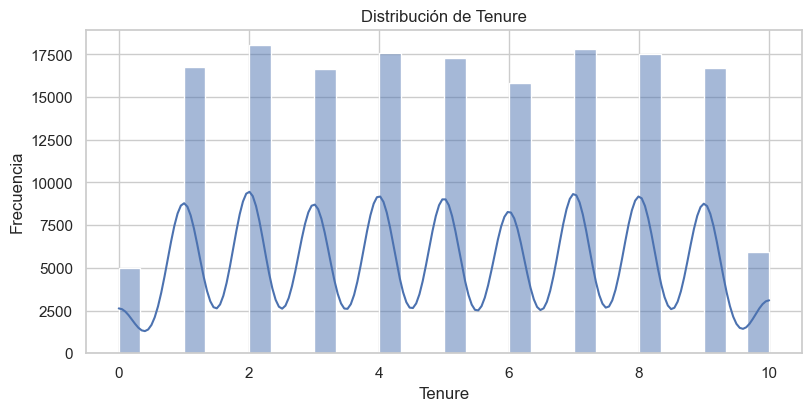

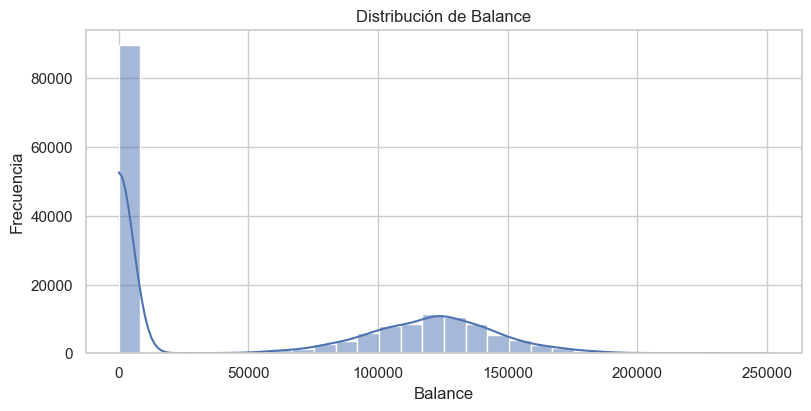

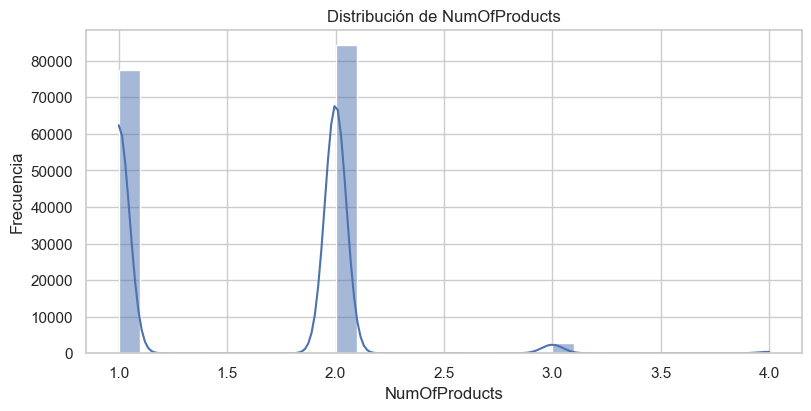

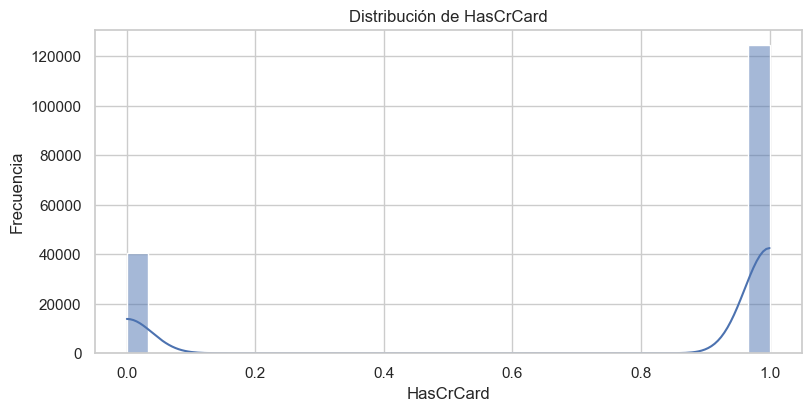

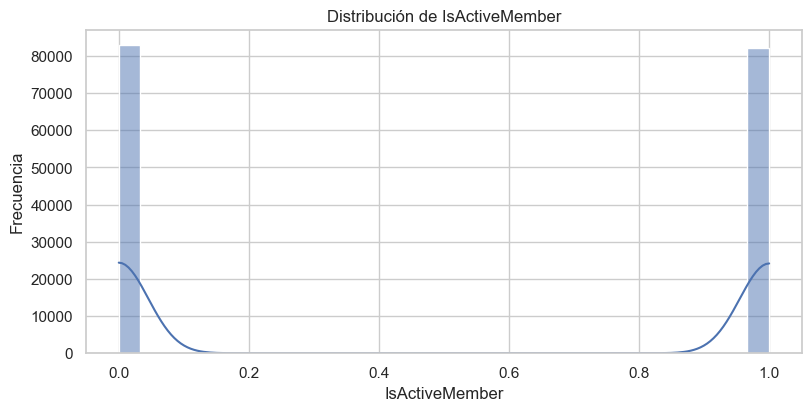

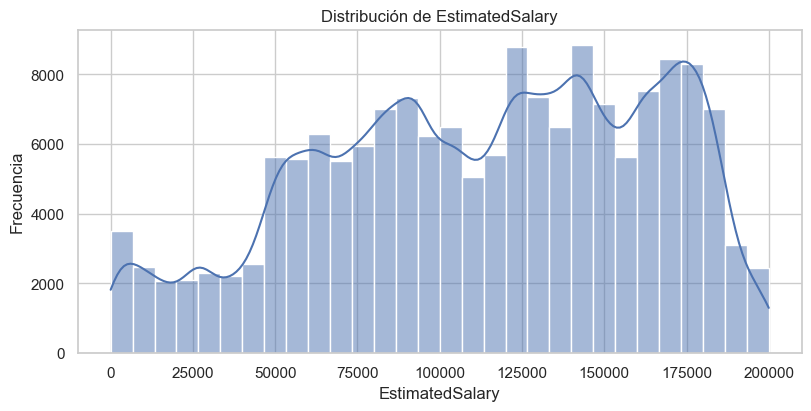

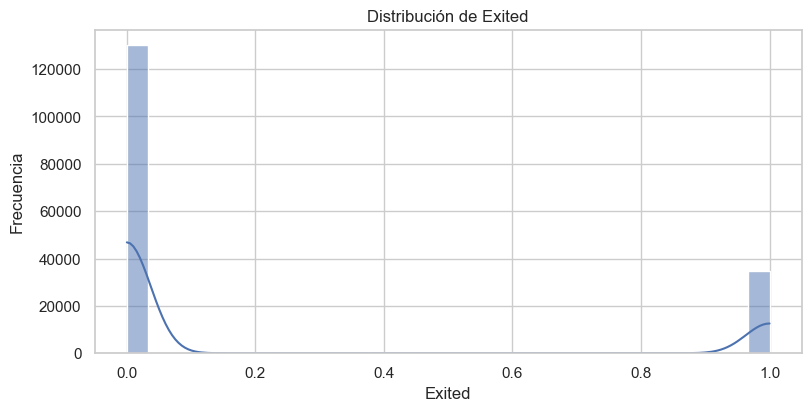

In [7]:
numericas = train.select_dtypes(include=['int64', 'float64']).columns

for col in numericas:
    plt.figure(figsize=(8,4))
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()


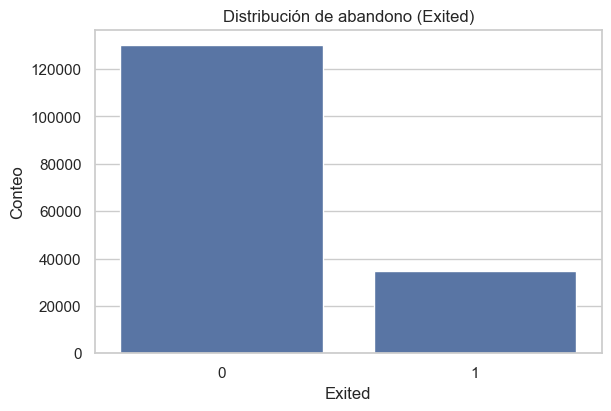

Porcentaje de abandono:
Exited
0    78.840118
1    21.159882
Name: proportion, dtype: float64


In [8]:
# Distribución de variable respuesta
plt.figure(figsize=(6,4))
sns.countplot(x='Exited', data=train)
plt.title("Distribución de abandono (Exited)")
plt.xlabel("Exited")
plt.ylabel("Conteo")
plt.show()

# Porcentaje de abandono
print("Porcentaje de abandono:")
print(train['Exited'].value_counts(normalize=True) * 100)


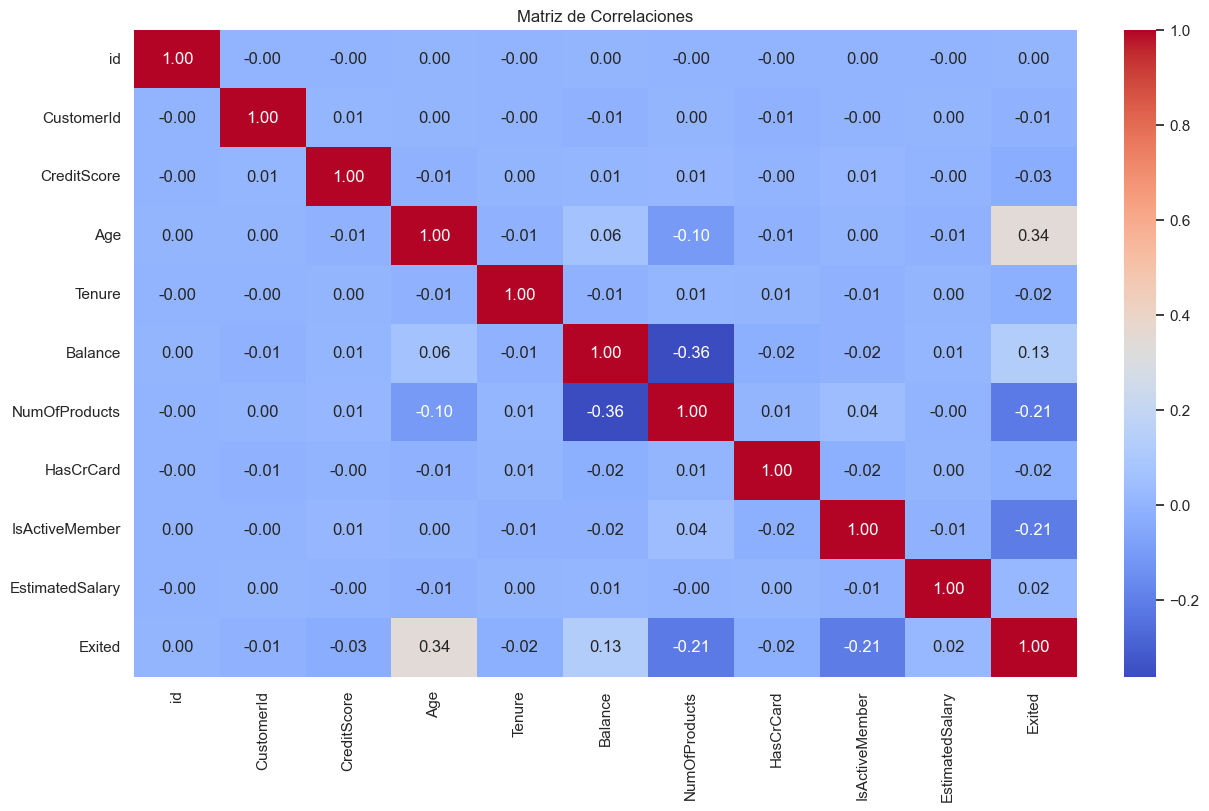

In [9]:
# Correlaciones numéricas
plt.figure(figsize=(12,8))
sns.heatmap(train.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlaciones")
plt.show()


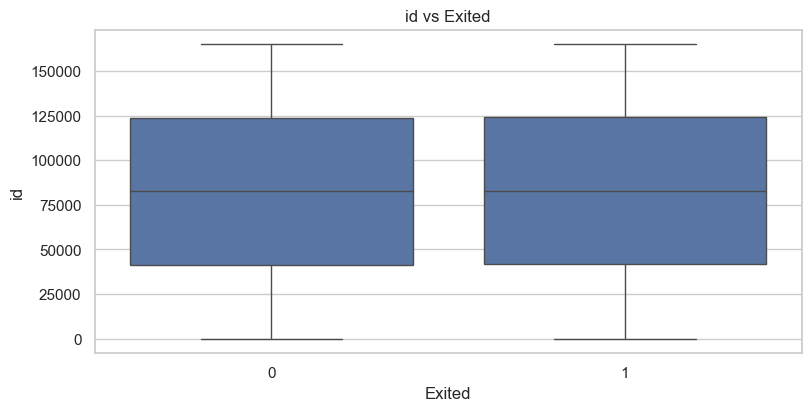

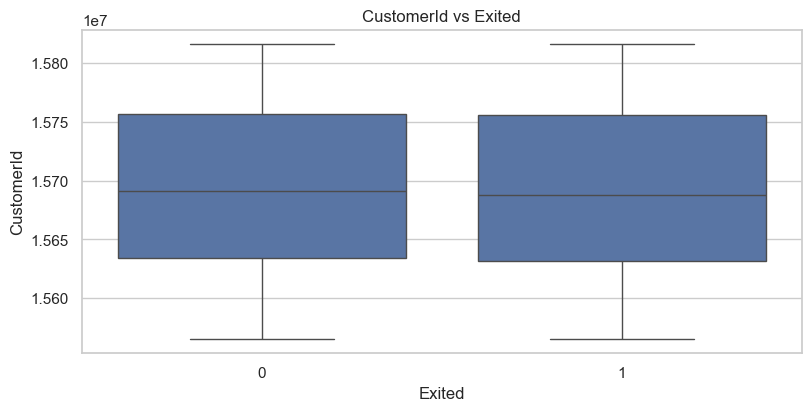

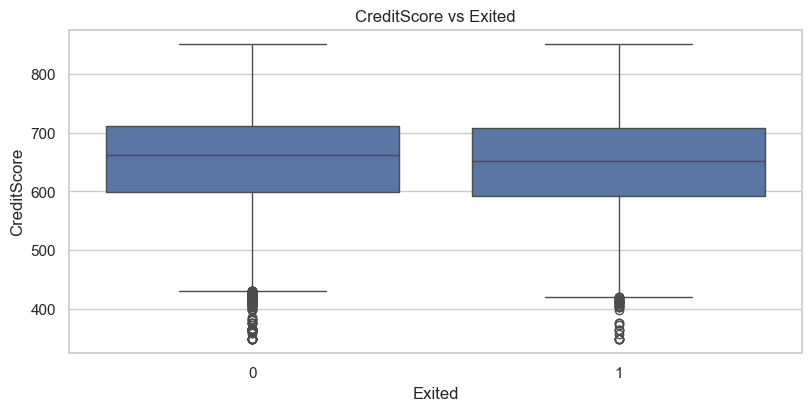

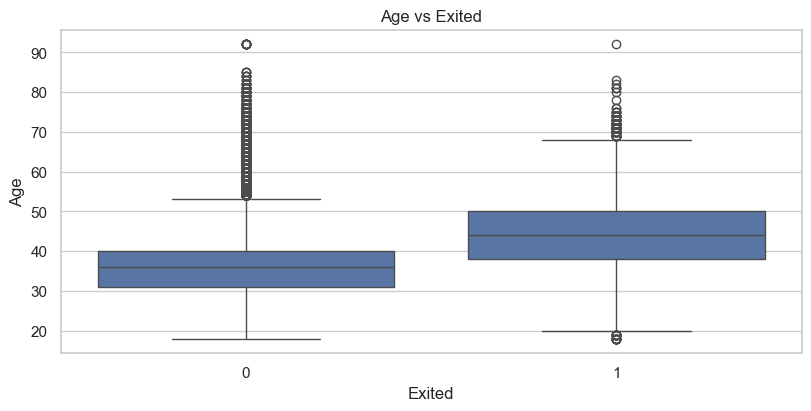

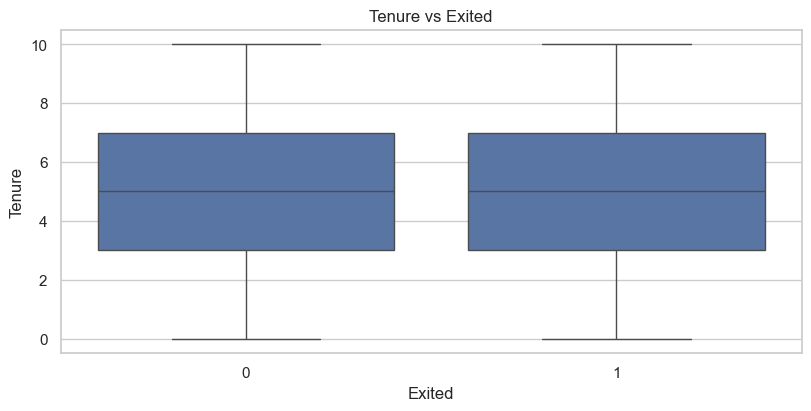

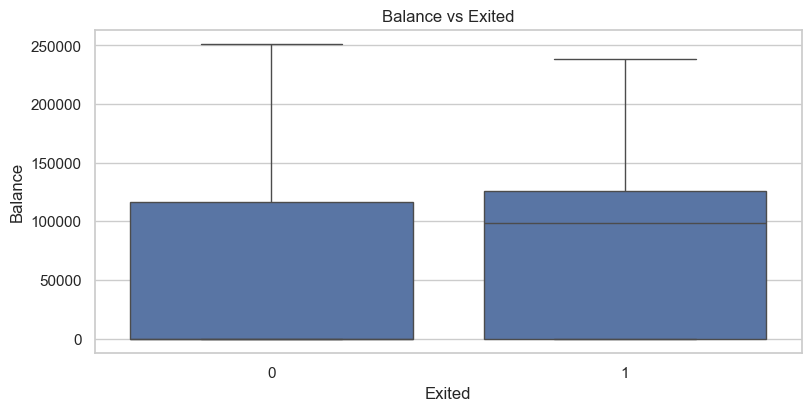

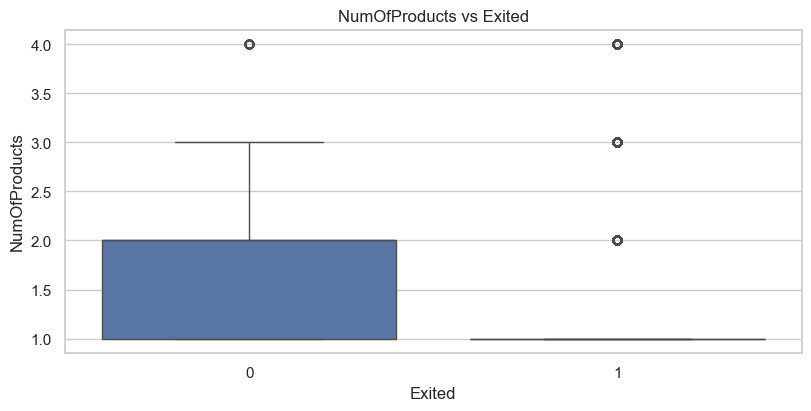

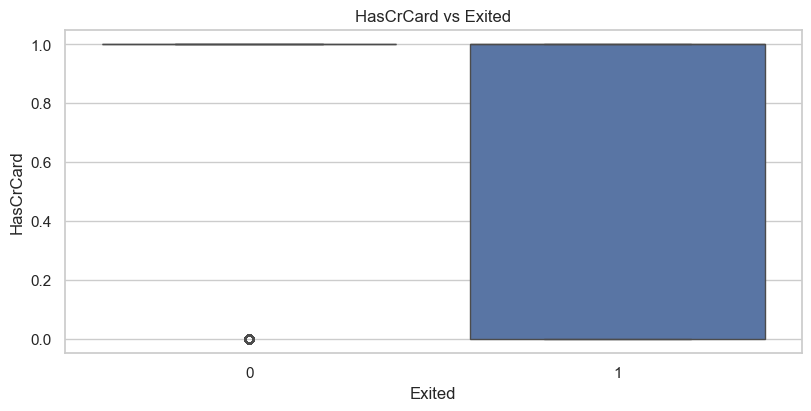

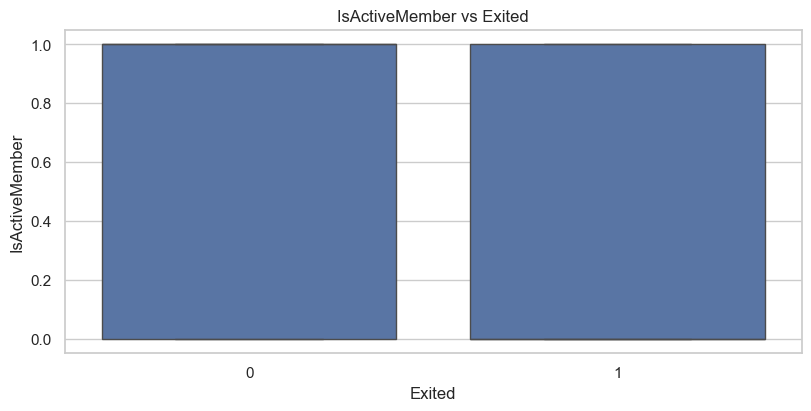

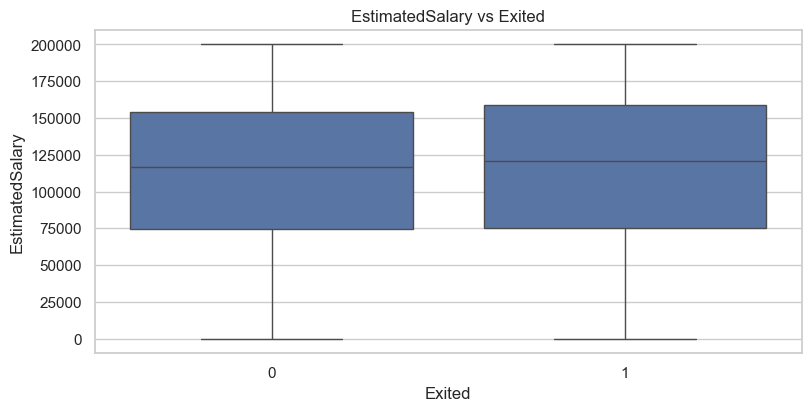

In [10]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop('Exited')

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='Exited', y=col, data=train)
    plt.title(f"{col} vs Exited")
    plt.show()


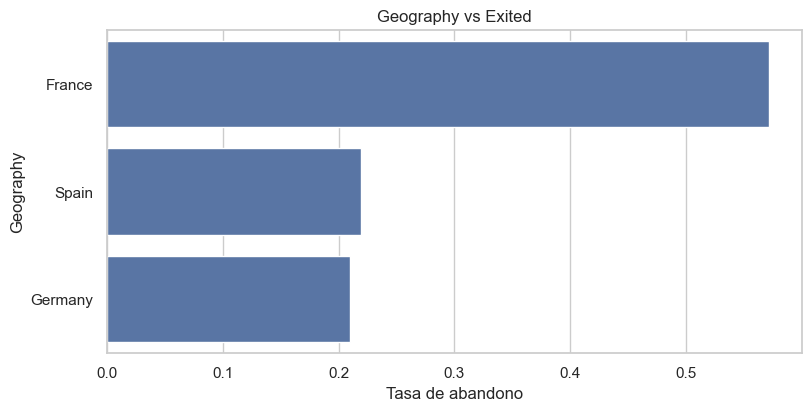

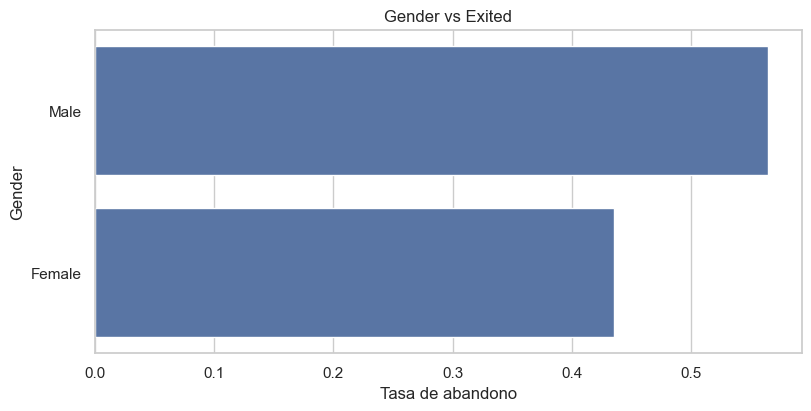

In [11]:
for col in categoricas:
    plt.figure(figsize=(8,4))
    sns.barplot(x='Exited', y=col, data=train, estimator=lambda x: len(x)/len(train))
    plt.title(f"{col} vs Exited")
    plt.xlabel("Tasa de abandono")
    plt.show()


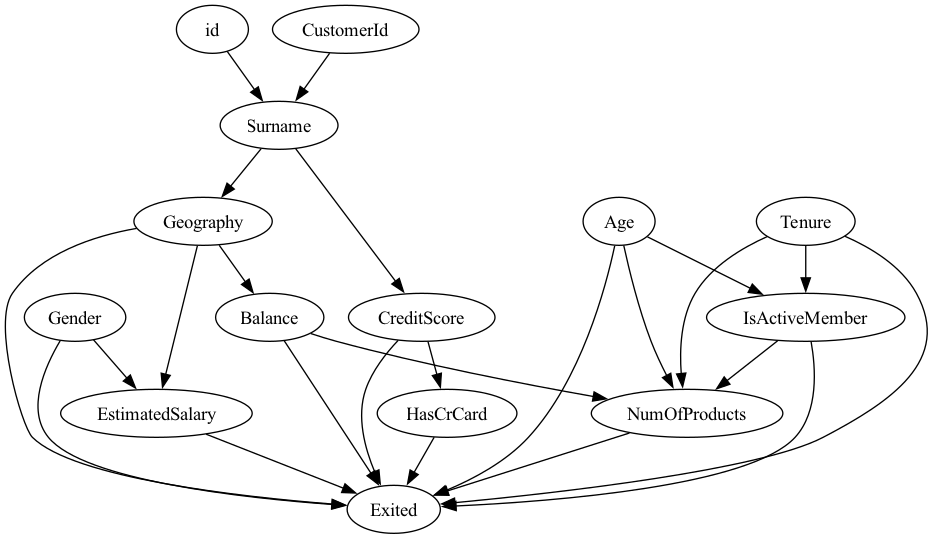

In [12]:
import graphviz
from IPython.display import Image, display

# DAG con todas las variables del dataset
dag_dot = """
digraph {
    // Identificadores (sin efecto causal directo)
    id -> Surname;
    CustomerId -> Surname;

    // Surname como proxy de origen o herencia
    Surname -> Geography;
    Surname -> CreditScore;

    // Relaciones conductuales y financieras
    Geography -> Balance;
    Geography -> EstimatedSalary;
    Geography -> Exited;

    Gender -> EstimatedSalary;
    Gender -> Exited;

    CreditScore -> Exited;
    CreditScore -> HasCrCard;

    Age -> IsActiveMember;
    Age -> NumOfProducts;
    Age -> Exited;

    Tenure -> IsActiveMember;
    Tenure -> NumOfProducts;
    Tenure -> Exited;

    Balance -> NumOfProducts;
    Balance -> Exited;

    HasCrCard -> Exited;

    IsActiveMember -> NumOfProducts;
    IsActiveMember -> Exited;

    NumOfProducts -> Exited;

    EstimatedSalary -> Exited;
}
"""

# Crear y renderizar el DAG
dag = graphviz.Source(dag_dot)
dag.render("dag_completo", format="png", cleanup=True)
display(Image(filename="dag_completo.png"))




**Queremos:**
- Quién se va a ir ?
- Porqué ?
- Qué hacemos con el desbalance de clases ? 

### Feature Engineering

In [13]:
# Copiar el DataFrame original para no sobreescribirlo
train_clean = train.copy()

# Eliminar columnas irrelevantes
train_clean = train_clean.drop(columns=['id', 'CustomerId', 'Surname'])

# Separar variables predictoras (X) y objetivo (y)
X = train_clean.drop(columns='Exited')
y = train_clean['Exited']

#Same for test
test_clean = test.copy()
test_clean = test_clean.drop(columns=['id', 'CustomerId', 'Surname'])



In [14]:
# ⚙️ Feature Engineering: nuevas variables derivadas

# 🧮 Balance promedio por producto: cuánto dinero tiene el cliente por cada producto contratado
# (Evitar dividir entre 0 usando .replace(0,1))
train_clean['BalancePerProduct'] = train_clean['Balance'] / train_clean['NumOfProducts'].replace(0, 1)

# 📊 Calidad crediticia ajustada por edad: clientes jóvenes con buen score se destacan más
train_clean['CreditScorePerAge'] = train_clean['CreditScore'] / train_clean['Age'].replace(0, 1)

# 👴 Identificador binario para clientes mayores (seniors): podrían tener comportamiento distinto
train_clean['IsSenior'] = (train_clean['Age'] > 60).astype(int)

# 🕓 Proporción de vida que han pasado en el banco: fidelidad relativa a la edad
train_clean['TenureRatio'] = train_clean['Tenure'] / train_clean['Age'].replace(0, 1)

# 💰 Etiqueta binaria para clientes con saldo alto: podrían tener más incentivos para quedarse
train_clean['HighBalance'] = (train_clean['Balance'] > 100000).astype(int)

# 🔁 Interacción entre score crediticio y nivel de actividad: combina dos señales de retención
train_clean['CreditActiveInteraction'] = train_clean['CreditScore'] * train_clean['IsActiveMember']


In [15]:
# Same for test
test_clean['BalancePerProduct'] = test_clean['Balance'] / test_clean['NumOfProducts'].replace(0, 1)
test_clean['CreditScorePerAge'] = test_clean['CreditScore'] / test_clean['Age'].replace(0, 1)
test_clean['IsSenior'] = (test_clean['Age'] > 60).astype(int)
test_clean['TenureRatio'] = test_clean['Tenure'] / test_clean['Age'].replace(0, 1)
test_clean['HighBalance'] = (test_clean['Balance'] > 100000).astype(int)
test_clean['CreditActiveInteraction'] = test_clean['CreditScore'] * test_clean['IsActiveMember']

# Verificar nuevas variables

print(test_clean.columns)

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'BalancePerProduct', 'CreditScorePerAge', 'IsSenior', 'TenureRatio',
       'HighBalance', 'CreditActiveInteraction'],
      dtype='object')


In [16]:
train_clean.dtypes

CreditScore                  int64
Geography                   object
Gender                      object
Age                        float64
Tenure                       int64
Balance                    float64
NumOfProducts                int64
HasCrCard                  float64
IsActiveMember             float64
EstimatedSalary            float64
Exited                       int64
BalancePerProduct          float64
CreditScorePerAge          float64
IsSenior                     int64
TenureRatio                float64
HighBalance                  int64
CreditActiveInteraction    float64
dtype: object

In [17]:
test_clean.dtypes

CreditScore                  int64
Geography                   object
Gender                      object
Age                        float64
Tenure                       int64
Balance                    float64
NumOfProducts                int64
HasCrCard                  float64
IsActiveMember             float64
EstimatedSalary            float64
BalancePerProduct          float64
CreditScorePerAge          float64
IsSenior                     int64
TenureRatio                float64
HighBalance                  int64
CreditActiveInteraction    float64
dtype: object

In [18]:
print(train_clean["Gender"].nunique())
print(train_clean["Geography"].nunique())

print(test_clean["Gender"].nunique())
print(test_clean["Geography"].nunique())


2
3
2
3


In [19]:
# 🎭 One-hot encoding: convierte 'Geography' y 'Gender' en variables binarias (0/1)
# drop_first=True elimina una categoría para evitar colinealidad
train_clean = pd.get_dummies(train_clean, columns=['Geography', 'Gender'], drop_first=True)

test_clean = pd.get_dummies(test_clean, columns=['Geography', 'Gender'], drop_first=True)


In [20]:
from sklearn.preprocessing import StandardScaler

# 🔍 Seleccionamos las columnas que queremos normalizar (todas excepto 'Exited')
features = train_clean.drop(columns='Exited').columns

# ⚖️ Creamos y aplicamos el escalador: convierte los datos a media 0 y varianza 1
scaler = StandardScaler()
train_clean[features] = scaler.fit_transform(train_clean[features])

test_clean[features] = scaler.transform(test_clean[features])


In [21]:
# 🧩 Separamos las variables predictoras (X) del objetivo (y)
X = train_clean.drop(columns='Exited').values  
y = train_clean['Exited'].values               #


In [22]:
print("Shape de X:", X.shape)

print("Shape de y:", y.shape)

print("Shape de test_clean:", test_clean.shape)


Shape de X: (165034, 17)
Shape de y: (165034,)
Shape de test_clean: (110023, 17)


In [23]:
test_clean.columns

# Verificar que las columnas de test_clean y train_clean coincidan
print("Columnas de train_clean:", train_clean.columns)
print("Columnas de test_clean:", test_clean.columns)
print("Columnas de test_clean que no están en train_clean:", set(test_clean.columns) - set(train_clean.columns))
print("Columnas de train_clean que no están en test_clean:", set(train_clean.columns) - set(test_clean.columns))

Columnas de train_clean: Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'BalancePerProduct',
       'CreditScorePerAge', 'IsSenior', 'TenureRatio', 'HighBalance',
       'CreditActiveInteraction', 'Geography_Germany', 'Geography_Spain',
       'Gender_Male'],
      dtype='object')
Columnas de test_clean: Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'BalancePerProduct',
       'CreditScorePerAge', 'IsSenior', 'TenureRatio', 'HighBalance',
       'CreditActiveInteraction', 'Geography_Germany', 'Geography_Spain',
       'Gender_Male'],
      dtype='object')
Columnas de test_clean que no están en train_clean: set()
Columnas de train_clean que no están en test_clean: {'Exited'}


---

#### Borderline - SMOTE 

In [24]:
# NO SE HACE SMOTE EN TEST SOLO EN TRAIN 

from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

smote = BorderlineSMOTE(kind='borderline-1', random_state=42)

# Solo sobre el set de entrenamiento
X_train_res, y_train_res = smote.fit_resample(X, y)

print(Counter(y_train_res))  # Verificar que quedó balanceado


Counter({0: 130113, 1: 130113})


In [28]:
import tensorflow as tf
from tensorflow_probability import layers as tfpl



In [29]:
# Definición de la entrada del modelo, especificando el tamaño de la entrada.
# `shape=(32,)` indica que la entrada es un vector unidimensional con 32 características.
inputs = tf.keras.Input(shape=(32,))  # Tamaño de la entrada (32 valores por ejemplo)

# Añadimos una capa bayesiana densa con Flipout.
# `128` es el número de unidades en la capa, `relu` es la función de activación.
# `DenseFlipout` es una capa densa especial para redes neuronales bayesianas (usando el método Flipout).
x = tfpl.DenseFlipout(128, activation='relu')(inputs)  
# Esto significa que estamos agregando una capa densa con 128 unidades y una activación ReLU, 
# además de aplicar la técnica de inferencia bayesiana (Flipout).

# Agregamos una capa de Dropout con una tasa de deserción de 50% (probabilidad de que una unidad se apague).
# `Dropout` es una técnica de regularización para prevenir el sobreajuste (overfitting).
# El valor de 0.5 significa que el 50% de las unidades se desactivan aleatoriamente durante el entrenamiento.
x = tf.keras.layers.Dropout(0.5)(x)

# Agregamos otra capa densa bayesiana Flipout con una única unidad de salida.
# Usamos una función de activación `sigmoid` porque estamos en un problema de clasificación binaria (salida entre 0 y 1).
# `DenseFlipout(1, activation='sigmoid')` indica que la salida será un solo valor entre 0 y 1, 
# utilizando la activación sigmoide que es común en clasificación binaria.
outputs = tfpl.DenseFlipout(1, activation='sigmoid')(x)

# Creamos el modelo de Keras, indicando las entradas y las salidas.
# `inputs=inputs` y `outputs=outputs` definen el flujo de datos en la red.
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Imprimimos un resumen del modelo, que muestra las capas, la cantidad de parámetros, la forma de las entradas y salidas.
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_flipout_2 (DenseFlip  (None, 128)               8320      
 out)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_flipout_3 (DenseFlip  (None, 1)                 257       
 out)                                                            
                                                                 
Total params: 8577 (33.50 KB)
Trainable params: 8577 (33.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
